In [52]:
import pandas as pd
import multiprocessing as mp
import wtfutil as wtf
import pathlib
import datetime as datetime
import os
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

In [53]:
DATE_REF=dt.datetime.utcnow().date() - dt.timedelta(days=1)
PATH_PREFIX=DATE_REF.strftime('data/%Y/%m/%d/')

rawdata = dict()
dfs = dict()

def process(path, buckets=20):
    _, timestamp, _ = path.name.split('_')
    ts = pd.Timestamp(dt.datetime.fromtimestamp(int(timestamp)))
    
    
    df = pq.read_table(path.open('rb')).to_pandas().query('diff == 1')
    agg = wtf.feeagg(df, buckets=buckets)
    series = [agg[c].add_prefix(f'{c}-').add_suffix(f'_{buckets}') for c in agg.columns]
    
    return (ts, pd.concat(series))

def mp_load(date_ref, use_cache=True):
    
    if not date_ref in rawdata or use_cache == False:
        with mp.Pool(16) as p:
            path_prefix = date_ref.strftime('data/%Y/%m/%d/')
            it_paths = pathlib.Path(path_prefix).glob('*_diff.parq')
            rawdata[date_ref] = p.map(process, it_paths)
            
    return rawdata[date_ref]


In [54]:
len(list(pathlib.Path(PATH_PREFIX).glob('*_diff.parq')))

5601

In [44]:
%%time

# load it into memory (may take 60 seconds)
for i in range(1):
    date_ref = datetime.datetime.utcnow().date() - datetime.timedelta(days=2) - datetime.timedelta(days=i)
    n = mp_load(date_ref, False)


    


CPU times: user 1.46 s, sys: 212 ms, total: 1.68 s
Wall time: 9.48 s


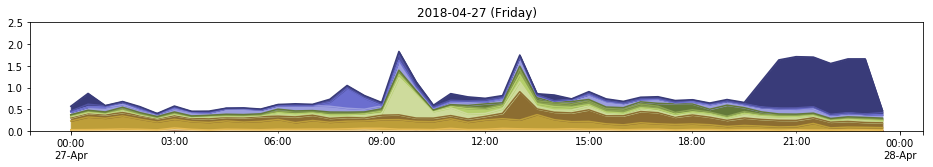

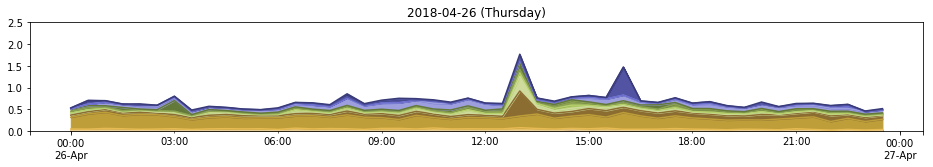

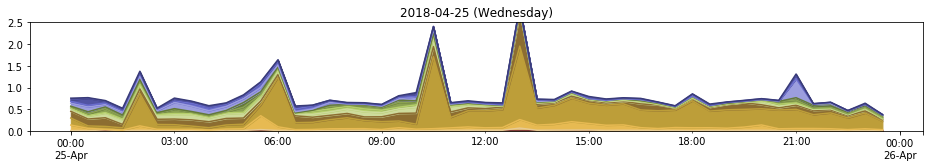

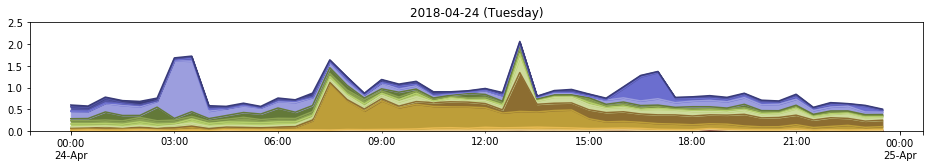

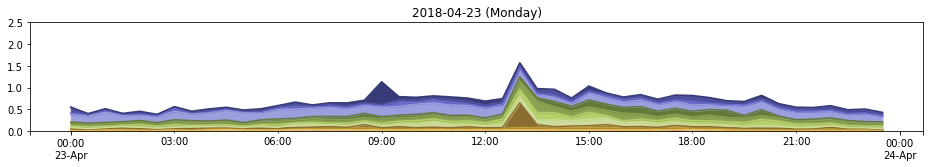

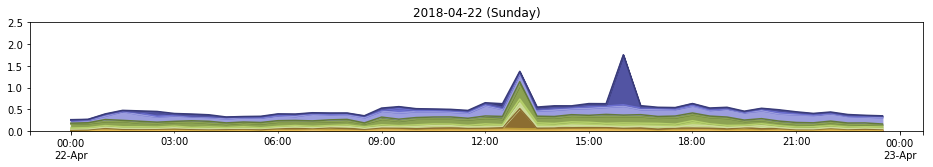

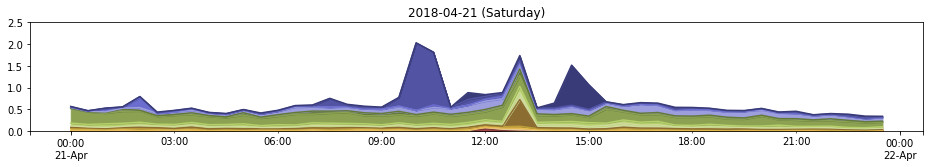

CPU times: user 15.8 s, sys: 5.38 s, total: 21.2 s
Wall time: 1min 13s


In [33]:
%%time

for i in range(7):
    date_ref = datetime.datetime.utcnow().date() - datetime.timedelta(days=1) - datetime.timedelta(days=i)
    res = mp_load(date_ref)
    ts = res[0][0]
    empty_df = pd.DataFrame(index=pd.date_range(ts.date(), periods=60*60*24/15, freq='15S'))
    partial_df = pd.DataFrame.from_items(res).T
    full_df = pd.concat([empty_df, partial_df], axis=1)
    
    title = date_ref.strftime('%Y-%m-%d (%A)')
    resampled_df = full_df.resample('30T', convention='s').sum()/3
    fig = plt.figure(figsize=(16,2), dpi=72)
    ax = plt.subplot(111)
    ax.set_ylim([0,2.5])
    cols = list(filter(lambda x: x.startswith('mvs'), resampled_df.columns))[::-1]

    resampled_df[cols].plot(kind='area', stacked=True, colormap='tab20b_r', ax=ax, legend=False, title=title)

    plt.show()


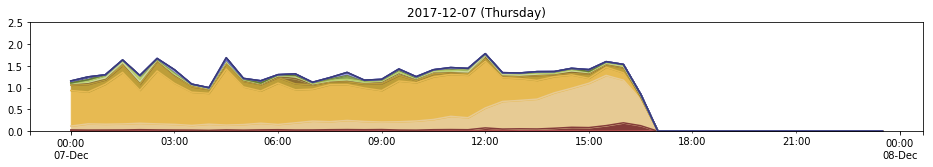

In [29]:
for i in range(1):
    date_ref = datetime.datetime.utcnow().date() - datetime.timedelta(days=0) - datetime.timedelta(days=i)
    res = mp_load(date_ref)
    ts = res[0][0]
    empty_df = pd.DataFrame(index=pd.date_range(ts.date(), periods=60*60*24/15, freq='15S'))
    partial_df = pd.DataFrame.from_items(res).T
    full_df = pd.concat([empty_df, partial_df], axis=1)
    
    title = date_ref.strftime('%Y-%m-%d (%A)')
    resampled_df = full_df.resample('30T', convention='s').sum()/3
    fig = plt.figure(figsize=(16,2), dpi=72)
    ax = plt.subplot(111)
    ax.set_ylim([0,2.5])
    cols = list(filter(lambda x: x.startswith('mvs'), resampled_df.columns))[::-1]

    resampled_df[cols].plot(kind='area', stacked=True, colormap='tab20b_r', ax=ax, legend=False, title=title)

    plt.show()
